In [14]:
import numpy as np
from math import sqrt
from skimage.transform import resize
import sys
import cv2
import numpy as np
import cv2
import glob
import random
import pandas as pd
from matplotlib.image import imsave
import mahotas as mh
from scipy import ndimage
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from itertools import islice
from IPython.display import display_html
from statsmodels.regression.linear_model import OLS as lm
from IPython.display import display, HTML

sns.set_style("white", {'axes.grid' : False})
%matplotlib inline
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')
random.seed(1337)

In [15]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


In [16]:
def predict_areas(input_img,mu=False,no=False):
    labels, no_objects = ndimage.label(255-input_img)
    props=regionprops(labels) 
    size={i:props[i].area for i in range (0, no_objects)}
    areas=[float(i) * (0.615**2) for i in size.values() if float(i) * (0.615**2) >= 200 and float(i) * (0.615**2) <= 16000]
    no_of_cells=len(areas)
    if mu and no:
        return(areas,np.mean(areas),no_of_cells)
    elif mu:
        return(areas,np.mean(areas))
    else:
        return(areas)

In [17]:
def plot_me(img_list,x=5,y=3,figsize=(15,25)):
    i = 1
    fig = plt.figure(figsize=figsize)
    for r in random.sample(img_list,len(img_list)):
        ax = fig.add_subplot(x,y,i)
        i+=1
        plt.imshow(plt.imread(r))
        plt.title('%s - %s'%(r.split('/')[2].split('_')[0],r.split('/')[2].split('_')[1]),fontsize=16)

In [63]:
import pandas as pd

test_tiles=sorted(glob.glob('../Julius_histology/*/*'))
test_tiles[0:5]


['../Julius_histology/m006/m006_SC_ (1).tif',
 '../Julius_histology/m006/m006_SC_ (10).tif',
 '../Julius_histology/m006/m006_SC_ (11).tif',
 '../Julius_histology/m006/m006_SC_ (12).tif',
 '../Julius_histology/m006/m006_SC_ (13).tif']

In [64]:
seg_masks = sorted(glob.glob('predicted_masks/julius/*'))
seg_masks[0:5]

['predicted_masks/julius/m006_SC_ (1).tifmask.png',
 'predicted_masks/julius/m006_SC_ (10).tifmask.png',
 'predicted_masks/julius/m006_SC_ (11).tifmask.png',
 'predicted_masks/julius/m006_SC_ (12).tifmask.png',
 'predicted_masks/julius/m006_SC_ (13).tifmask.png']

In [65]:
tissue_depot = [x.split('_')[2] for x in seg_masks]

In [66]:
tissue_depot = [x.split(' ')[0] for x in tissue_depot]

In [67]:
for x,index in enumerate(tissue_depot):
    if x =='sc':
        tissue_depot[index] = 'SC'

In [68]:
len(test_tiles),len(seg_masks),len(tissue_depot)

(6122, 6122, 6122)

In [69]:
# count cells and measure their areas from the stored, predicted, segmentation masks.

In [139]:
# example prediction

ex_img = cv2.imread(seg_masks[0],0)

cell_areas,mu_area,no_cells = predict_areas(ex_img,mu=True,no=True)

print('Average adipocyte area for this tile is {0:.1f}um and number of\
 cells present is {1:}'.format(mu_area,no_cells))


Average adipocyte area for this tile is 3535.1um and number of cells present is 61


example segmentation masks - majority are high quality. False segmentations such as background are filtered out - For some poor quality tiles - segmentations will also be bad - will assess suitable threshold.

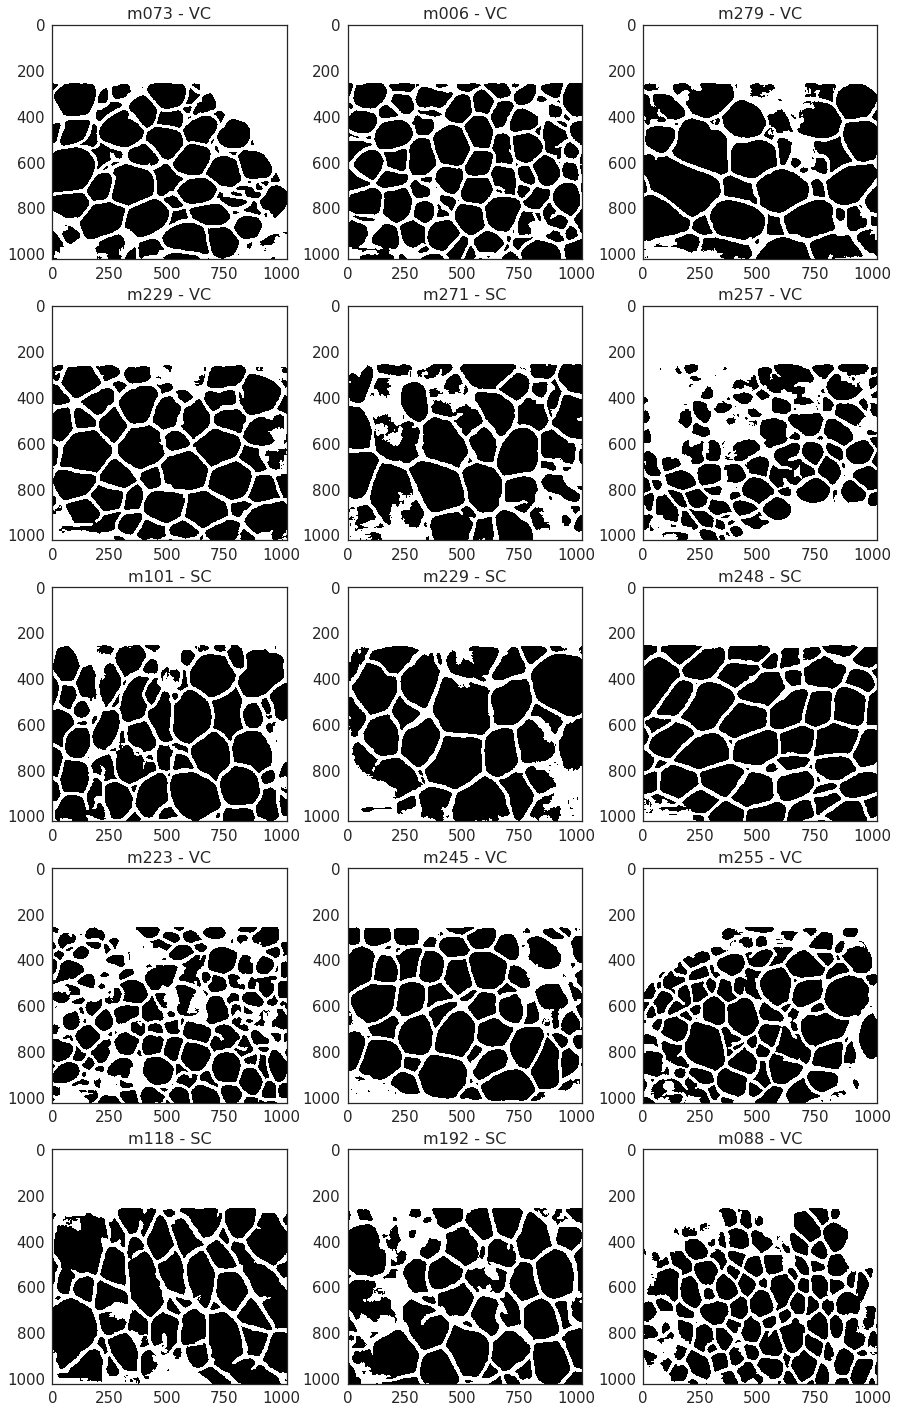

In [143]:
plot_me(list(np.random.choice(seg_masks,size=15)))

In [144]:
from tqdm import tqdm

In [145]:
#For each preproduced segmentation mask, calculate the area of all cells, the average and the count 
measurements = []
with open('julius_areas','w') as out:
    for i in tqdm(seg_masks):
        prd_meas = predict_areas(cv2.imread(i,0))
        # list of cell areas, followed by average area and count of cells.
        measurements.append(prd_meas)

measurements = np.array(measurements)
np.save('julius_measurements.npy',measurements)

100%|██████████| 6122/6122 [04:23<00:00, 22.78it/s]


In [70]:
# run the above cell previously, so we'll load in the data now.
measurements = np.load('julius_measurements.npy')

QC step:
Find all the tiles that have a cell count less than 10 ( Visually, even these low count segmentations look great)


In [71]:
from operator import itemgetter

# # find all the tiles that have a cell count less than 10 ( Visually, many of these low count segmentations don't look great)
# indices=[idx for (idx,item) in enumerate(measurements) if len(item) <=20]
# plot_me(itemgetter(*indices)(seg_masks)[0:100],x=1,y=5,figsize=(25,10))

In [72]:
len(test_tiles),len(seg_masks),len(measurements)


(6122, 6122, 6122)

In [73]:
seg_masks_filt = seg_masks
measurements_filt = measurements


In [74]:
len(seg_masks_filt),len(measurements_filt),len(tissue_depot)

(6122, 6122, 6122)

In [75]:
print('Total number of cells measured in experiment: {}'.format(sum([len(a) for a in measurements_filt])))

Total number of cells measured in experiment: 354115


In [76]:
# create list of indexes that seperate subcutaneous from visceral tiles.
subq_tiles_filt = list(np.where(np.array(tissue_depot) =='SC')[0])
visceral_tiles_filt = list(np.where(np.array(tissue_depot) =='VC')[0])

In [77]:

print('subq: {}, visceral: {}, total tiles: {}'.format(len(subq_tiles_filt),len(visceral_tiles_filt),len(visceral_tiles_filt)+len(subq_tiles_filt)))

subq: 2936, visceral: 3176, total tiles: 6112


In [78]:
# obtain subq and visceral measurements
subq_measurements_filt = itemgetter(*subq_tiles_filt)(measurements_filt)
visceral_measurements_filt = itemgetter(*visceral_tiles_filt)(measurements_filt)

subq_seg_masks_filt=itemgetter(*subq_tiles_filt)(seg_masks_filt)
visceral_seg_masks_filt=itemgetter(*visceral_tiles_filt)(seg_masks_filt)

In [79]:
np.save('all_cell_measurements_julius',[seg_masks_filt,measurements_filt])

In [80]:
subq_mean_areas = np.array([np.mean(i) for i in subq_measurements_filt])
visc_mean_areas = np.array([np.mean(i) for i in visceral_measurements_filt])

In [81]:
subq_areas = pd.DataFrame(
    {'mean_areas': subq_mean_areas,
     'tissue': np.repeat('Subcutaneous',len(subq_mean_areas))
    })

visc_areas = pd.DataFrame(
    {'mean_areas': visc_mean_areas,
     'tissue': np.repeat('Visceral',len(visc_mean_areas))
    })

In [144]:
from scipy import stats
from scipy.stats import ttest_ind as ttest

print('Clear difference in means between depots:-\nSubq: {0:.2f} +/- {1:.2f} \nVisceral:\
 {2:.2f} +/- {3:.2f}'.format(np.nanmean(subq_mean_areas),np.nanstd(subq_mean_areas),
                             np.nanmean(visc_mean_areas),np.nanstd(visc_mean_areas)))

#ttest(subq_mean_areas,visc_mean_areas,equal_var=False)

Clear difference in means between depots:-
Subq: 3684.04 +/- 1049.46 
Visceral: 2874.72 +/- 1046.84


In [82]:
# all_areas=pd.concat([subq_areas,visc_areas])
# all_areas.head()

**Now, we need to operate at the individual sample level. So we will create a dictionary {Julius_ID}: [areas]**

In [83]:
from collections import defaultdict

subq_samples=defaultdict(list)
visc_samples=defaultdict(list)

In [84]:
# Some Subq samples have no tiles after this filtering.
for i,a in enumerate(subq_measurements_filt):
    julius_id = subq_seg_masks_filt[i].split('/')[2].split('_')[0]
    try:
        if len(subq_measurements_filt[i]) == 0:
            next
        else:
            subq_samples[julius_id].append(subq_measurements_filt[i])
    except KeyError:
        if len(subq_measurements_filt[i]) == 0:
            next
        else:
            subq_samples[julius_id] = subq_measurements_filt[i]

In [85]:
# Some Subq samples have no tiles after this filtering.
for i,a in enumerate(visceral_measurements_filt):
    julius_id = visceral_seg_masks_filt[i].split('/')[2].split('_')[0]
    try:
        if len(visceral_measurements_filt[i]) == 0:
            next
        else:
            visc_samples[julius_id].append(visceral_measurements_filt[i])
    except KeyError:
        if len(visceral_measurements_filt[i]) == 0:
            next
        else:
            visc_samples[julius_id] = visceral_measurements_filt[i]

In [86]:
example_id = [item for sublist in subq_samples['m152'] for item in sublist]
print('m152 has {} tiles containing {} unique adipocyte measurements'.format(len(subq_samples['m152']),
                                                                             len(example_id)))

m152 has 12 tiles containing 499 unique adipocyte measurements


In [87]:
# lets set a seed and do some random sampling. We want to assess how the variance changes for adipocyte
# area estimates when measuring 3, 10, 100, 500 and 1000 cells.

np.random.seed(1337)
def simulate_cells(n,data,mean=True):
    sub=[]
    for i in range(100):
        if mean == True:
            sub.append(statistics.mean(np.random.choice(data,n)))
        else:
            sub.append(statistics.stdev(np.random.choice(data,n)))
    return (sub)
    

In [88]:
three = simulate_cells(n=3,data=example_id)
ten = simulate_cells(n=10,data=example_id)
hundred = simulate_cells(n=100,data=example_id)
fivehundred = simulate_cells(n=500,data=example_id)
thousand = simulate_cells(n=1000,data=example_id)

In [89]:
simulation = pd.DataFrame(
    {'1000': thousand,
     '500': fivehundred,
     '100': hundred,
     '10':ten,
     '3': three
    })

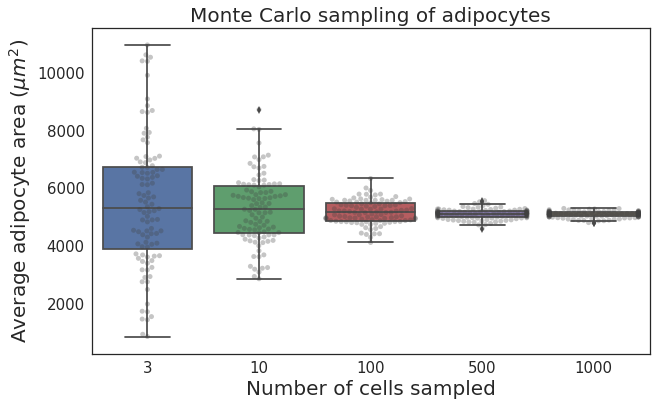

In [140]:
plt.figure(figsize=(10,6))
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
sns.set_style("white")
ax = sns.boxplot(data=simulation,order=['3','10','100','500','1000'])
ax = sns.swarmplot(data=simulation, color=".25",order=['3','10','100','500','1000'],alpha=.3)
plt.xlabel('Number of cells sampled',fontsize=20)
plt.ylabel('Average adipocyte area ($\mu m^{2}$)',fontsize=20)
plt.title('Monte Carlo sampling of adipocytes',fontsize=20)
plt.savefig('mc_sampling_GOBB.pdf')

**Lets assess how many cells we have measured per sample (on average)**

In [91]:
subq_no_cells_per_sample=[]
for key,value in subq_samples.items():
    subq_no_cells_per_sample.append(len([item for sublist in subq_samples[key] for item in sublist]))

visc_no_cells_per_sample=[]
for key,value in visc_samples.items():
    visc_no_cells_per_sample.append(len([item for sublist in visc_samples[key] for item in sublist]))

In [92]:
subq_no_tiles_per_sample=[]
for key,value in subq_samples.items():
    subq_no_tiles_per_sample.append(len([item for item in subq_samples[key]]))

visc_no_tiles_per_sample=[]
for key,value in visc_samples.items():
    visc_no_tiles_per_sample.append(len([item for item in visc_samples[key]]))

In [93]:
print('Subcutaneous histology samples on average have {0:.0f} cells measured'.format(np.mean(subq_no_cells_per_sample)))

Subcutaneous histology samples on average have 757 cells measured


In [94]:
print('Visceral fat histology samples on average have {0:.0f} cells measured'.format(np.mean(visc_no_cells_per_sample)))

Visceral fat histology samples on average have 938 cells measured


In [95]:
# return the key value at the nth position in a dictionary
def ix(dic, n): 
   try:
       return list(dic)[n]
   except IndexError:
       print('not enough keys')

In [96]:
#which sample has the lowest number of adipocytes counted?
ix(dic=subq_samples,n=np.argmin(subq_no_cells_per_sample))

'm138'

In [97]:
#which sample has the highest number of adipocytes counted?
ix(dic=subq_samples,n=np.argmax(subq_no_cells_per_sample))

'm197'

In [98]:
# plot subcutaneous and visceral cell distributions on a single plot.
# calculate adipocyte area mean and variance.

In [99]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [100]:
len(subq_samples),len(visc_samples)

(204, 212)

**We will randomly select 1000 cells from each sample to measure.**

In [101]:
subq_sample_areas={}

for key,value in subq_samples.items():
    tmp = [item for sublist in value for item in sublist]
    tmp = [x for x in tmp if x <= 30000]
    if len(tmp) >=500:
        selection = np.random.choice(tmp,500)
        small_std = np.mean(selection) - np.std(selection)
        high_std = np.mean(selection) + np.std(selection)
        small = sum([a < small_std for a in selection])
        large = sum([a > high_std for a in selection])
        ratio_s = small/(large+small)
        
        subq_sample_areas[key] = np.mean(selection),np.std(selection),ratio_s
    else:
        next

visc_sample_areas={}

for key,value in visc_samples.items():
    tmp = [item for sublist in value for item in sublist]
    tmp = [x for x in tmp if x <= 30000]
    if len(tmp) >=500:
        selection = np.random.choice(tmp,500)
        small_std = np.mean(selection) - np.std(selection)
        high_std = np.mean(selection) + np.std(selection)
        small = sum([a < 2000 for a in selection])
        large = sum([a > 4000 for a in selection])
        ratio_s = small/(large+small)
        
        visc_sample_areas[key] = np.mean(selection),np.std(selection),ratio_s
    else:
        next

In [102]:
for i,v in take(10,subq_sample_areas.items()):
    print(i,v)

m090 (2443.77148455, 2198.103197320581, 0.20454545454545456)
m060 (3046.3308094499994, 2376.1162545125794, 0.4838709677419355)
m092 (5069.976015599999, 4188.452255788406, 0.5169082125603864)
m069 (4171.4783216999995, 3704.2721000767892, 0.3357142857142857)
m197 (2293.8226704000003, 1983.109272259625, 0.3770491803278688)
m228 (3067.1899182, 2439.837404039396, 0.5272727272727272)
m216 (3207.0537409499993, 2522.9418849398317, 0.5)
m084 (3651.4204595999995, 3246.6014267769574, 0.3125)
m231 (4960.180323899999, 3945.371805880892, 0.49710982658959535)
m106 (2944.37496555, 2763.161531408843, 0.0)


In [104]:

# lets convert the dictionaries into dataframes so we can add and analyse additional covariates
subq_sample_area_df = pd.DataFrame(subq_sample_areas).T.rename_axis('sampleID').add_prefix('Area').reset_index()
subq_sample_area_df.columns = ['SUBJID', 'mu_area','var_area','per_small_cells']

visc_sample_area_df = pd.DataFrame(visc_sample_areas).T.rename_axis('sampleID').add_prefix('Area').reset_index()
visc_sample_area_df.columns = ['SUBJID', 'mu_area','var_area','per_small_cells']

In [105]:
# lets have a quick look at both the subQ table so far:
display_side_by_side(subq_sample_area_df.head(), visc_sample_area_df.head())


,SUBJID,mu_area,var_area,per_small_cells
0,m006,4047.788156,3297.369069,0.485876
1,m008,2532.574176,2290.045861,0.120000
2,m040,3619.663176,2805.933806,0.494048
3,m043,3961.506713,2959.459997,0.528409
4,m048,3359.916400,2961.787725,0.368056
,SUBJID,mu_area,var_area,per_small_cells
0,m006,2962.615244,2368.738396,0.586022
1,m008,1752.850479,1245.782490,0.918079
2,m027,2399.963952,2139.590057,0.732984
3,m040,3820.172351,3073.911268,0.480418


In [4]:
# subq_sample_area_df = pd.read_csv('final_cohort_measurements/Julius_Subcutaneous_areas.csv')
# visc_sample_area_df = pd.read_csv('final_cohort_measurements/Julius_Visceral_areas.csv')

Lets look at the distribution of mean adipocyte area across samples:

Text(0.5, 0, 'Mean Adipocyte Area ($\\mu m^{2}$)')

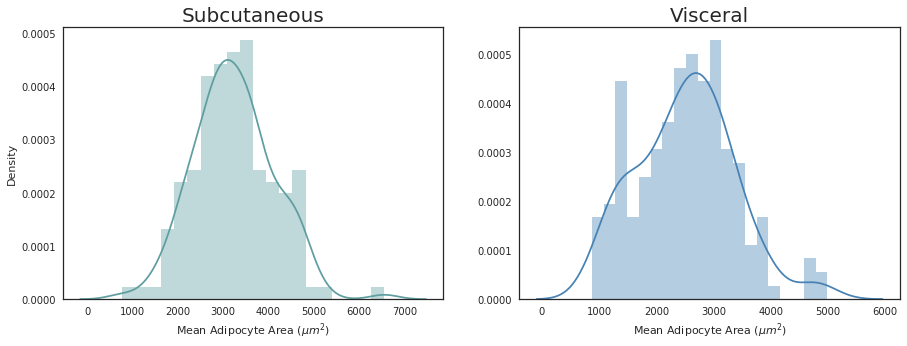

In [5]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
sns.distplot(np.array(subq_sample_area_df['mu_area'].tolist()),color='cadetblue',bins=20)
plt.title('Subcutaneous',size=20)
plt.xlabel('Mean Adipocyte Area ($\mu m^{2}$)')
plt.ylabel('Density')

ax = fig.add_subplot(1,2,2)
sns.distplot(np.array(visc_sample_area_df['mu_area'].tolist()),color='steelblue',bins=20)
plt.title('Visceral',size=20)
plt.xlabel('Mean Adipocyte Area ($\mu m^{2}$)')


In [6]:
from scipy import stats
from scipy.stats import ttest_ind as ttest

test_stats=ttest(np.array(visc_sample_area_df['mu_area'].tolist()),np.array(subq_sample_area_df['mu_area'].tolist()),equal_var=False)

print('T-stastistic is: {0:.3f} with P-value = {1}'.format(test_stats[0],test_stats[1]))

T-stastistic is: -7.583 with P-value = 3.646743660111141e-13


In [7]:
print('The mean adipocyte areas are: \nSubcutaneous: {0:.2f}\nVisceral: {1:.2f}'.format(np.mean(subq_sample_area_df['mu_area']),np.mean(visc_sample_area_df['mu_area'])))

The mean adipocyte areas are: 
Subcutaneous: 3238.74
Visceral: 2513.08


In [33]:
np.std(subq_sample_area_df['mu_area']),np.std(visc_sample_area_df['mu_area'])

(880.4833632561238, 850.3578063352355)

**Lets load in the Julius sample and phenotype attributes, expand table with potentially relevant variables:**

In [109]:
import pandas as pd
phenotypes = pd.read_csv('20180115_GOBB_Phenotype_CLEAN.csv',delimiter=',')

In [110]:
phenotypes.head()

,Number,Gender,Age,Height,Weight,BMI,Hip_cm,waist_cm,T2D,Comorbidities,...,Vitamin B1 (µg/l),Vitamin B2 (µg/l),Vitamin B6 (µg/l),Vitamin B12 (pg/ml),Vitamin D (nmol/l),Vitamin E (µmol/l),Folic acid (ng/ml),Zinc (µg/dl),Selenium (µg/l),Vitamin K (μg/l)
0,m001,f,51,1.585,147.4,58.67,162.0,135.0,N,Cholesterin erhöht; Hypertonie; hat 02/2011 Ma...,...,63.6,227.4,12.6,372,30.4,28.7,6.6,80,71.9,0.172
1,m002,m,56,1.650,175.0,64.28,NaN,NaN,Y,"Arterielle Hypertonie, Asthma bronchiale, Diab...",...,70.9,"270,8",17.6,173,61,34.3,6.2,90,117,0.317
2,m003,f,36,1.780,119.0,37.56,NaN,NaN,N,"Höchstgewicht war 130 kg, Schlafapnoe",...,66.1,208.8,13.3,394,28.7,24.8,6.2,70,54.1,0.213
3,m004,m,35,1.800,204.4,63.09,NaN,NaN,N,"204 kg Höchstgewicht, arterielle Hypertonie, a...",...,68.8,124.4,16,362,8.9,26,3,70,73.2,0.223
4,m005,m,23,1.900,170.0,47.09,NaN,NaN,N,"177 kg Höchstgewicht, Hypertonie, Hyperthyreose",...,"71,3",208.8,"32,8",234,10,"20,7",4.8,80,62.9,0.6


In [111]:
np.mean(phenotypes['Age'])

46.47709923664122

In [112]:
phenotypes['BMI']=np.array(pd.to_numeric(phenotypes['BMI'], errors='coerce'))

In [113]:
phenotypes['Weight']=np.array(pd.to_numeric(phenotypes['Weight'], errors='coerce'))

In [114]:
phenotypes['C-Peptide (ng/ml)']=np.array(pd.to_numeric(phenotypes['C-Peptide (ng/ml)'], errors='coerce'))

In [115]:
phenotypes['C-Peptide (ng/ml)'][phenotypes['C-Peptide (ng/ml)'] > 50] = 0

In [116]:
phenotypes['Height']=np.array(pd.to_numeric(phenotypes['Height'], errors='coerce'))

In [117]:
phenotypes['Hip_cm']=np.array(pd.to_numeric(phenotypes['Hip_cm'], errors='coerce'))

In [118]:
phenotypes['waist_cm']=np.array(pd.to_numeric(phenotypes['waist_cm'], errors='coerce'))

In [119]:
phenotypes['WHR'] = phenotypes['waist_cm'] / phenotypes['Hip_cm']

In [120]:
subq_pheno_merged=pd.merge(subq_sample_area_df,phenotypes,left_on='SUBJID', right_on='Number')
visc_pheno_merged=pd.merge(visc_sample_area_df,phenotypes,left_on='SUBJID', right_on='Number')


In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression as lm_regress

Correlation between mean adipocyte area and BMI

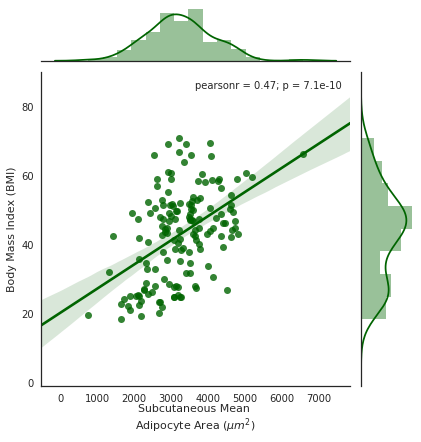

In [10]:
sns.jointplot(x=subq_pheno_merged['mu_area'],y=subq_pheno_merged['BMI'],color='darkgreen',kind='reg')
plt.xlabel('Subcutaneous Mean \nAdipocyte Area ($\mu m^{2}$)')
plt.ylabel('Body Mass Index (BMI)')
plt.savefig('GOBB_bmi_subq.pdf')

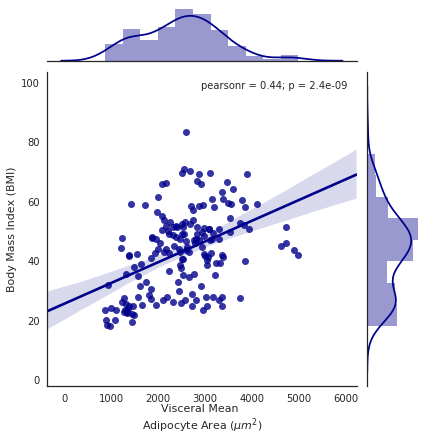

In [11]:
sns.jointplot(x=visc_pheno_merged['mu_area'],y=visc_pheno_merged['BMI'],color='darkblue',kind='reg')
plt.xlabel('Visceral Mean \nAdipocyte Area ($\mu m^{2}$)')
plt.ylabel('Body Mass Index (BMI)')
plt.savefig('GOBB_bmi_visc.pdf')

In [12]:
def r_SE(x,n):
    return sqrt((float(1)-(x**2))/float(n -2))

**t-test for mean difference between males and females**

In [13]:
groupM = subq_pheno_merged.where(subq_pheno_merged['Gender']== 'm')['mu_area'].dropna()
groupF = subq_pheno_merged.where(subq_pheno_merged['Gender']== 'f')['mu_area'].dropna()

In [14]:
ttest(groupM,groupF)

Ttest_indResult(statistic=-1.6656864160772118, pvalue=0.09780880501728824)

In [15]:
np.std(groupM),np.std(groupF)

(774.4580917494187, 919.1078919576178)

In [16]:
groupM = visc_pheno_merged.where(visc_pheno_merged['Gender']== 'm')['mu_area'].dropna()
groupF = visc_pheno_merged.where(visc_pheno_merged['Gender']== 'f')['mu_area'].dropna()

In [17]:
ttest(groupM,groupF)

Ttest_indResult(statistic=0.9699341027976819, pvalue=0.33343343480378496)

In [18]:
np.std(groupM),np.std(groupF)

(971.0210267205954, 779.9430206977863)

In [19]:
len(subq_pheno_merged),len(visc_pheno_merged)

(156, 175)

In [20]:
subq_pheno_merged['depot'] = np.repeat('subcutaneous',len(subq_pheno_merged))
visc_pheno_merged['depot'] = np.repeat('visceral',len(visc_pheno_merged))

In [21]:
both_depot_pheno=pd.concat([subq_pheno_merged,visc_pheno_merged])

In [22]:
# both_depot_pheno['Gender']=both_depot_pheno['Gender'].astype('category')
# both_depot_pheno.Gender.replace(['m', 'f'], ['XY', 'XX'], inplace=True)
both_depot_pheno=both_depot_pheno.rename(columns={'Gender': 'sex'})


In [23]:
len(subq_pheno_merged),len(visc_pheno_merged)

(156, 175)

How many XY and XX?

In [24]:
subq_pheno_merged.head()
subq_pheno_merged['Gender'].value_counts()

f    103
m     53
Name: Gender, dtype: int64

In [25]:
both_depot_pheno.sex.replace(['m', 'f'],['XY', 'XX'], inplace=True)

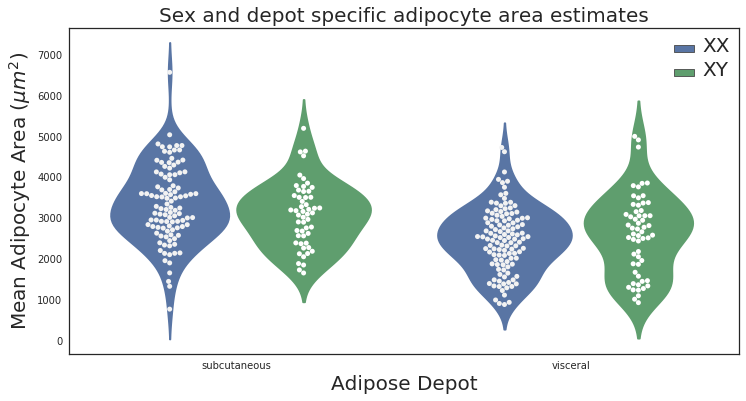

In [26]:
# # by depot and sex
fig = plt.figure(figsize=(12,6))
# ax.grid(b="off")
ax=sns.violinplot(y='mu_area',x='depot',hue='sex',data=both_depot_pheno,inner=None)
ax = sns.swarmplot(x="depot", y="mu_area", hue="sex",
                     data=both_depot_pheno, split=True,color="white", edgecolor="gray")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.xlabel('Adipose Depot',fontsize='20') 
plt.ylabel("Mean Adipocyte Area ($\mu m^{2}$)",fontsize='20')
plt.title("Sex and depot specific adipocyte area estimates",fontsize='20')
plt.savefig('gobb_sex_depot.pdf')

In [31]:
bins=[15,25,35,45,55,65,75]
both_depot_pheno['BMI Bins'] = pd.cut(both_depot_pheno['BMI'], bins)

[None, None, None, None, None, None, None, None, None, None, None, None]

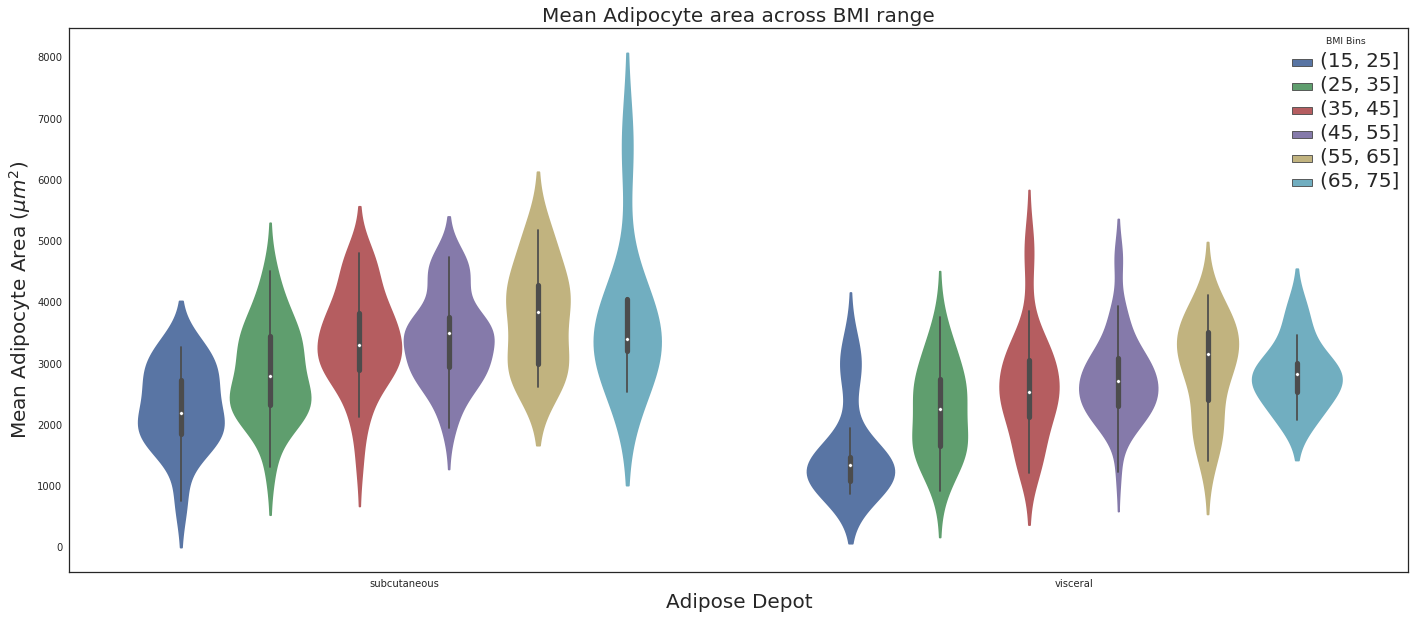

In [32]:
# by depot and sex
fig = plt.figure(figsize=(24,10))
ax.grid(b="off")
ax=sns.violinplot(y='mu_area',x='depot',hue='BMI Bins',data=both_depot_pheno)
plt.xlabel('Adipose Depot',fontsize=20)
plt.ylabel('Mean Adipocyte Area ($\mu m^{2}$)',fontsize=20)
plt.title('Mean Adipocyte area across BMI range',fontsize =20)
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text


In [84]:
subq_pheno_merged.to_csv('Julius_Subcutaneous_areas.csv')
len(subq_pheno_merged)

142

In [85]:
visc_pheno_merged.to_csv('Julius_Visceral_areas.csv')
len(visc_pheno_merged)

171

In [86]:
both_depot_pheno.to_csv('Julius_BothDepots_areas.csv')
len(both_depot_pheno)

313

Subject with the lowest and highest adipocyte area variance:

In [87]:
subq_pheno_merged['SUBJID'][np.argmin(subq_pheno_merged['var_area'])],
subq_pheno_merged['SUBJID'][np.argmax(subq_pheno_merged['var_area'])]

'm158'

Subject with the lowest and highest adipocyte area mean:

In [88]:
subq_pheno_merged['SUBJID'][np.argmin(subq_pheno_merged['mu_area'])],
subq_pheno_merged['SUBJID'][np.argmax(subq_pheno_merged['mu_area'])]

'm158'

In [89]:
min_mean = []
for i in seg_masks_filt:
    exeter_id = i.split('/')[2].split('_')[0]
    if exeter_id == subq_pheno_merged['SUBJID'][np.argmin(subq_pheno_merged['mu_area'])]:
        print(i)
        min_mean.append(i)
        

predicted_masks/julius/m055_SC_ (1).tifmask.png
predicted_masks/julius/m055_SC_ (2).tifmask.png
predicted_masks/julius/m055_SC_ (3).tifmask.png
predicted_masks/julius/m055_SC_ (4).tifmask.png
predicted_masks/julius/m055_SC_ (5).tifmask.png
predicted_masks/julius/m055_SC_ (6).tifmask.png
predicted_masks/julius/m055_SC_ (7).tifmask.png
predicted_masks/julius/m055_SC_ (8).tifmask.png
predicted_masks/julius/m055_VC_ (1).tifmask.png
predicted_masks/julius/m055_VC_ (2).tifmask.png
predicted_masks/julius/m055_VC_ (3).tifmask.png


In [90]:
max_mean = []
for i in seg_masks_filt:
    exeter_id = i.split('/')[2].split('_')[0]
    if exeter_id == subq_pheno_merged['SUBJID'][np.argmax(subq_pheno_merged['mu_area'])]:
        print(i)
        max_mean.append(i)
        

predicted_masks/julius/m158_SC_ (1).tifmask.png
predicted_masks/julius/m158_SC_ (10).tifmask.png
predicted_masks/julius/m158_SC_ (11).tifmask.png
predicted_masks/julius/m158_SC_ (12).tifmask.png
predicted_masks/julius/m158_SC_ (13).tifmask.png
predicted_masks/julius/m158_SC_ (14).tifmask.png
predicted_masks/julius/m158_SC_ (15).tifmask.png
predicted_masks/julius/m158_SC_ (16).tifmask.png
predicted_masks/julius/m158_SC_ (17).tifmask.png
predicted_masks/julius/m158_SC_ (18).tifmask.png
predicted_masks/julius/m158_SC_ (19).tifmask.png
predicted_masks/julius/m158_SC_ (2).tifmask.png
predicted_masks/julius/m158_SC_ (20).tifmask.png
predicted_masks/julius/m158_SC_ (21).tifmask.png
predicted_masks/julius/m158_SC_ (3).tifmask.png
predicted_masks/julius/m158_SC_ (4).tifmask.png
predicted_masks/julius/m158_SC_ (5).tifmask.png
predicted_masks/julius/m158_SC_ (6).tifmask.png
predicted_masks/julius/m158_SC_ (7).tifmask.png
predicted_masks/julius/m158_SC_ (8).tifmask.png
predicted_masks/julius/m158_

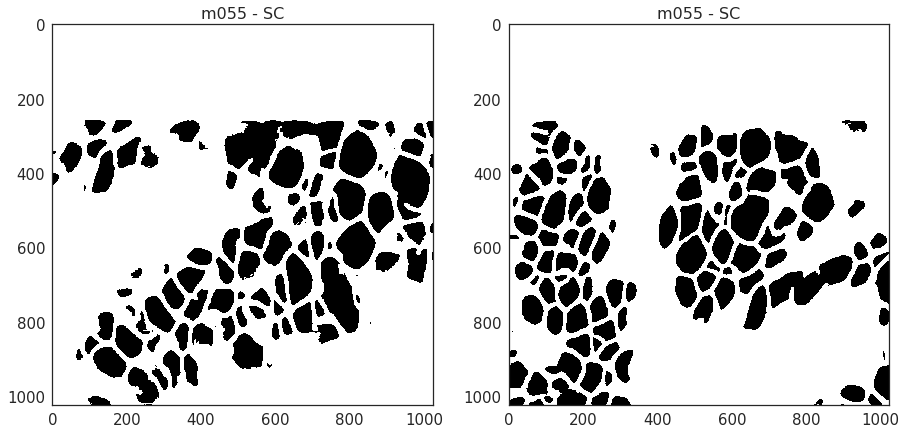

In [91]:
plot_me(min_mean[0:2],x=1,y=2)

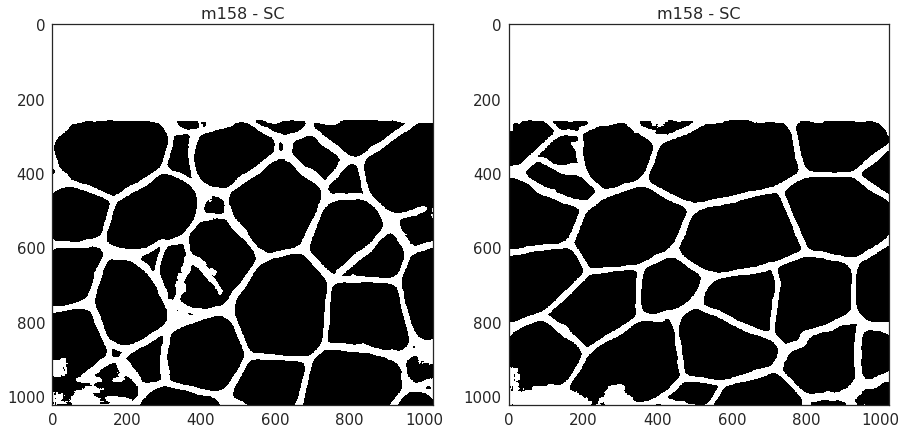

In [92]:
plot_me(max_mean[0:2],x=1,y=2)

**Lets explore some additional covariates measured on these cohorts (bloods):**

In [18]:
import pandas as pd
import numpy as np
both_depots = pd.read_csv('Julius_BothDepots_areas.csv',index_col=0)

In [19]:
both_depots.head()

,SUBJID,mu_area,var_area,per_small_cells,Number,sex,Age,Height,Weight,BMI,...,Vitamin B12 (pg/ml),Vitamin D (nmol/l),Vitamin E (µmol/l),Folic acid (ng/ml),Zinc (µg/dl),Selenium (µg/l),Vitamin K (μg/l),WHR,depot,BMI Bins
0,m006,3639.119070,2897.527794,0.467742,m006,XX,34,1.60,125.0,48.83,...,465,31.6,23.8,5.7,80,75.4,0.685,NaN,subcutaneous,NaN
1,m008,2372.373195,2128.045679,0.131868,m008,XX,52,1.61,90.0,34.72,...,298,48.9,33.2,5.4,70,81.5,0.548,NaN,subcutaneous,"(30, 45]"
2,m040,3690.123467,2792.146566,0.497326,m040,XY,48,1.80,169.0,52.16,...,258,7.3,44.2,15,81.6,93.6,0.08,0.862069,subcutaneous,NaN
3,m043,4020.878961,3121.282744,0.538012,m043,XX,54,1.58,133.8,53.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,subcutaneous,NaN
4,m048,3330.268856,2835.014118,0.428571,m048,XY,48,1.83,166.0,49.57,...,552,21,24.6,3.8,84.5,100,0.2,NaN,subcutaneous,NaN


In [20]:
both_depots.columns

Index(['SUBJID', 'mu_area', 'var_area', 'per_small_cells', 'Number', 'sex',
       'Age', 'Height', 'Weight', 'BMI', 'Hip_cm', 'waist_cm', 'T2D',
       'Comorbidities', 'Medication', 'Family anamnesis', 'CrP (mg/dl)',
       'Albumin Serum (mg/dl)', 'Prealbumin (mg/dl)',
       'fasting plasma-glucose (mg/dl)', 'fasting plasma-insulin (uU/ml)',
       'HbA1c\n(%)', 'total cholesterol (mg/dl)', 'LDL-C (mg/dl)',
       'HDL-C (mg/dl)', 'TG (mg/dl)', 'Lipoprotein (a) (nmol/l)',
       'Creatinine (mg/dl)', 'urea (mg/dl)', 'uric-acid (mg/dl)',
       'ALAT (GPT) (U/l)', 'ASAT (GOT) (U/l)', 'gGT (U/l)',
       'C-Peptide (ng/ml)', 'Na (mmol/l)', 'Ka (mmol/l)', 'Calcium (mmol/l)',
       'TSH (µU/ml)', 'Thyroxine T4 (ng/dl)', 'Thyroxine T3 (ng/dl)',
       'iron (µg/dl)', 'Ferritin (ng/ml)', 'Transferrin (mg/dl)',
       'transferrin-saturation %', 'Parathyroid hormone (pg/ml)',
       'Vitamin A (µmol/l)', 'Vitamin B1 (µg/l)', 'Vitamin B2 (µg/l)',
       'Vitamin B6 (µg/l)', 'Vitamin B12 (

In [21]:
both_depots.T2D.replace(['N', 'Y'], [0, 1], inplace=True)

In [22]:
both_subset = both_depots[['mu_area','per_small_cells','Age','BMI','WHR','CrP (mg/dl)',
             'Albumin Serum (mg/dl)','Prealbumin (mg/dl)','fasting plasma-glucose (mg/dl)',
            'fasting plasma-insulin (uU/ml)','HbA1c\n(%)','total cholesterol (mg/dl)',
            'LDL-C (mg/dl)','TG (mg/dl)','Lipoprotein (a) (nmol/l)','Creatinine (mg/dl)',
             'urea (mg/dl)','gGT (U/l)','C-Peptide (ng/ml)','TSH (µU/ml)','Thyroxine T4 (ng/dl)',
            'Thyroxine T3 (ng/dl)','T2D','depot']]

In [23]:
both_subset['CrP (mg/dl)']=np.array(pd.to_numeric(both_subset['CrP (mg/dl)'], errors='coerce'))
both_subset['Albumin Serum (mg/dl)']=np.array(pd.to_numeric(both_subset['Albumin Serum (mg/dl)'], errors='coerce'))
both_subset['Prealbumin (mg/dl)']=np.array(pd.to_numeric(both_subset['Prealbumin (mg/dl)'], errors='coerce'))
both_subset['fasting plasma-glucose (mg/dl)']=np.array(pd.to_numeric(both_subset['fasting plasma-glucose (mg/dl)'], errors='coerce'))
both_subset['fasting plasma-insulin (uU/ml)']=np.array(pd.to_numeric(both_subset['fasting plasma-insulin (uU/ml)'], errors='coerce'))
both_subset['HbA1c\n(%)']=np.array(pd.to_numeric(both_subset['HbA1c\n(%)'], errors='coerce'))
both_subset['total cholesterol (mg/dl)']=np.array(pd.to_numeric(both_subset['total cholesterol (mg/dl)'], errors='coerce'))

In [24]:
both_subset['LDL-C (mg/dl)']=np.array(pd.to_numeric(both_subset['LDL-C (mg/dl)'], errors='coerce'))
both_subset['TG (mg/dl)']=np.array(pd.to_numeric(both_subset['TG (mg/dl)'], errors='coerce'))
both_subset['Lipoprotein (a) (nmol/l)']=np.array(pd.to_numeric(both_subset['Lipoprotein (a) (nmol/l)'], errors='coerce'))
both_subset['Creatinine (mg/dl)']=np.array(pd.to_numeric(both_subset['Creatinine (mg/dl)'], errors='coerce'))
both_subset['urea (mg/dl)']=np.array(pd.to_numeric(both_subset['urea (mg/dl)'], errors='coerce'))
both_subset['gGT (U/l)']=np.array(pd.to_numeric(both_subset['gGT (U/l)'], errors='coerce'))
both_subset['C-Peptide (ng/ml)']=np.array(pd.to_numeric(both_subset['C-Peptide (ng/ml)'], errors='coerce'))
both_subset['TSH (µU/ml)']=np.array(pd.to_numeric(both_subset['TSH (µU/ml)'], errors='coerce'))
both_subset['Thyroxine T4 (ng/dl)']=np.array(pd.to_numeric(both_subset['Thyroxine T4 (ng/dl)'], errors='coerce'))
both_subset['Thyroxine T3 (ng/dl)']=np.array(pd.to_numeric(both_subset['Thyroxine T3 (ng/dl)'], errors='coerce'))

###
both_depots['Thyroxine T3 (ng/dl)'][both_depots['Thyroxine T3 (ng/dl)'] > '2'] = 'NaN'
both_subset['Albumin Serum (mg/dl)'][both_subset['Albumin Serum (mg/dl)'] < 100]  = 'NaN'

In [26]:
#both_subset['fasting plasma-insulin (uU/ml)']

In [27]:
subq_subset = both_subset[both_subset['depot'] =='subcutaneous']
visc_subset = both_subset[both_subset['depot'] =='visceral']
subq_subset = subq_subset.drop(['per_small_cells'],axis=1)
visc_subset = visc_subset.drop(['per_small_cells'],axis=1)
subq_subset = subq_subset.drop(['fasting plasma-insulin (uU/ml)'],axis=1)
visc_subset = visc_subset.drop(['fasting plasma-insulin (uU/ml)'],axis=1)

In [28]:
subq_subset = subq_subset.drop(['depot'],axis=1)
visc_subset = visc_subset.drop(['depot'],axis=1)

In [29]:
subq_corr = subq_subset.corr()
visc_corr = visc_subset.corr()

In [38]:
subq_corr.shape, visc_corr.shape

((20, 20), (20, 20))

In [39]:
mask_upper = np.zeros_like(subq_corr, dtype=np.bool)
mask_upper[np.triu_indices_from(mask_upper)] = True

mask_lower = np.zeros_like(visc_corr, dtype=np.bool)
mask_lower[np.tril_indices_from(mask_lower)] = True


In [46]:
combined_corr = np.array(np.zeros(shape=subq_corr.shape))
combined_corr[mask_lower] = subq_corr.as_matrix()[mask_upper]

In [47]:
combined_corr[mask_upper] = visc_corr.as_matrix()[mask_lower]

In [64]:
combined_corr = pd.DataFrame(combined_corr)
combined_corr.columns = subq_corr.columns
combined_corr.index = subq_corr.columns[::-1]

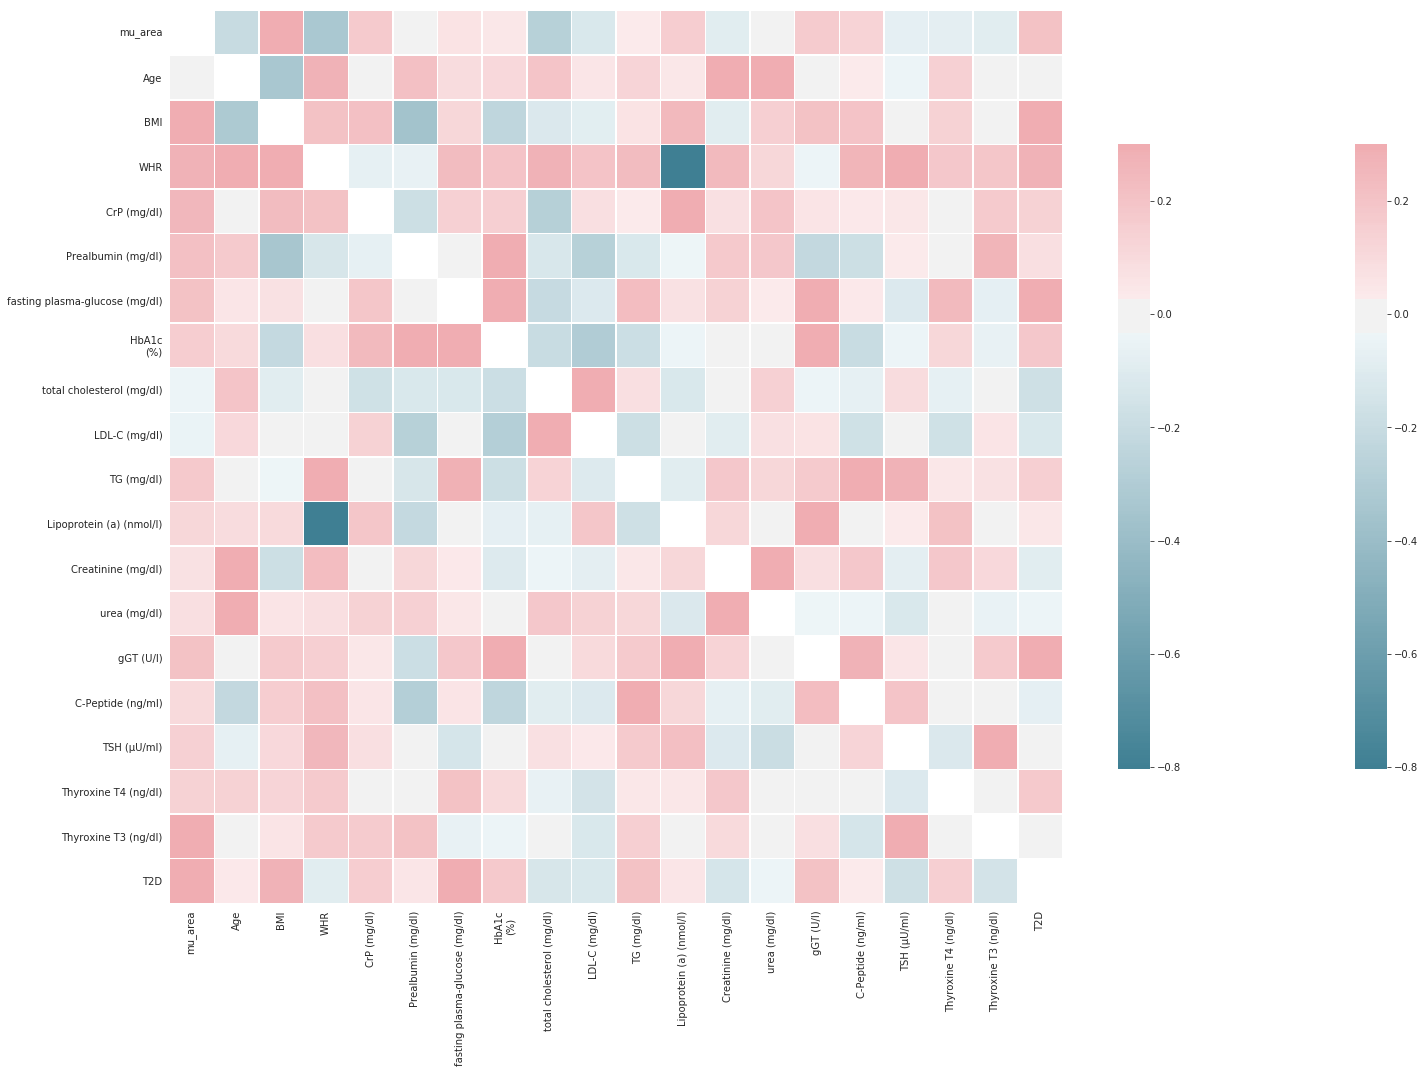

In [84]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 23))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(subq_corr, mask=mask_lower, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot_kws={"size":18})
sns.heatmap(visc_corr, mask=mask_upper, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot_kws={"size":18})


In [85]:
f.savefig('Joint_correlation_subq_visc_mobb.pdf')

Text(0.5, 1.0, 'Correlation of clinical covariates with visceral adipocyte morphology\n')

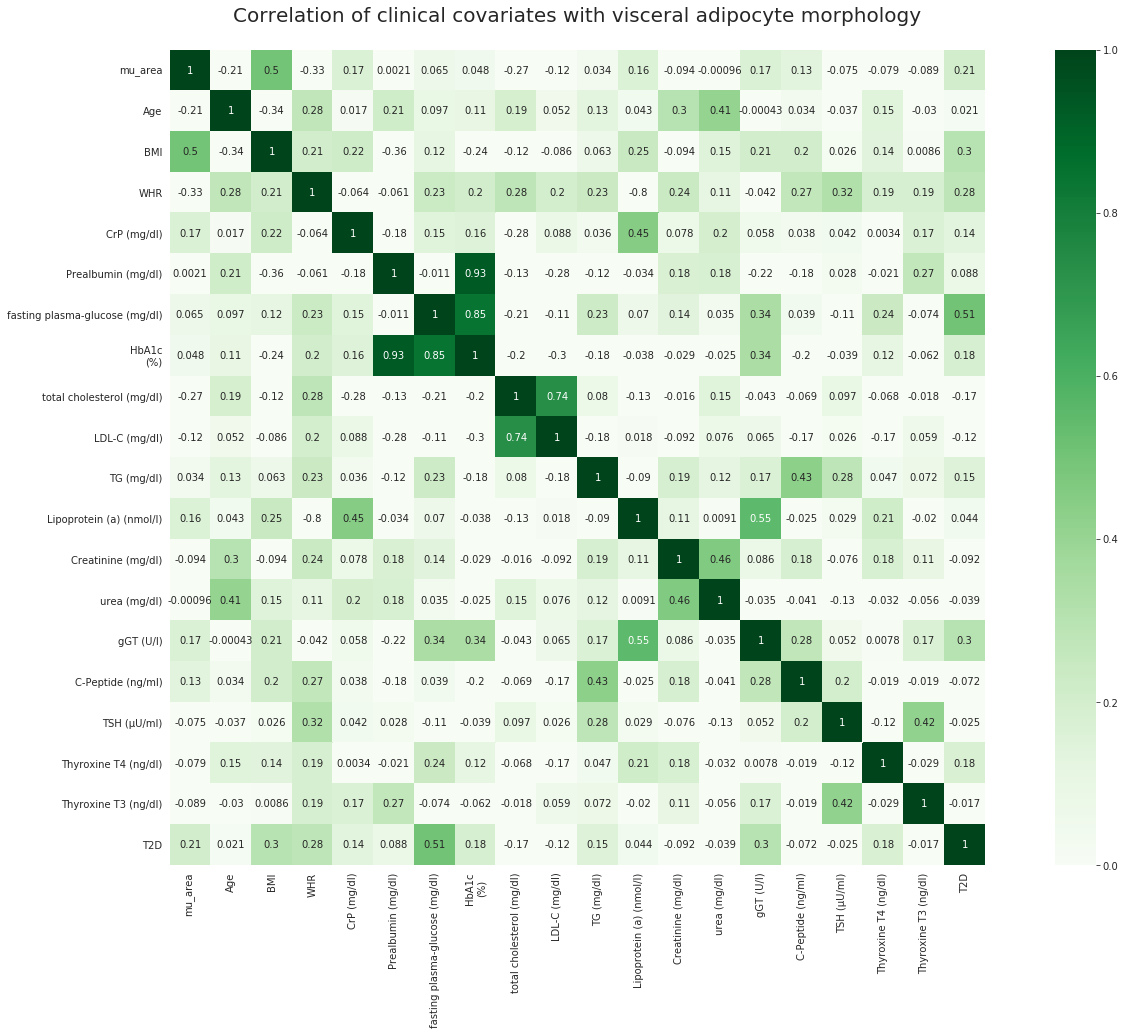

In [30]:
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(subq_corr, cmap='Greens',vmin=0,vmax=1,
            square=True, ax=ax,annot=True,robust=True)
ax.set_title('Correlation of clinical covariates with visceral adipocyte morphology\n',fontsize=20)

Text(0.5, 1.0, 'Correlation of clinical covariates with subcutaneous adipocyte morphology\n')

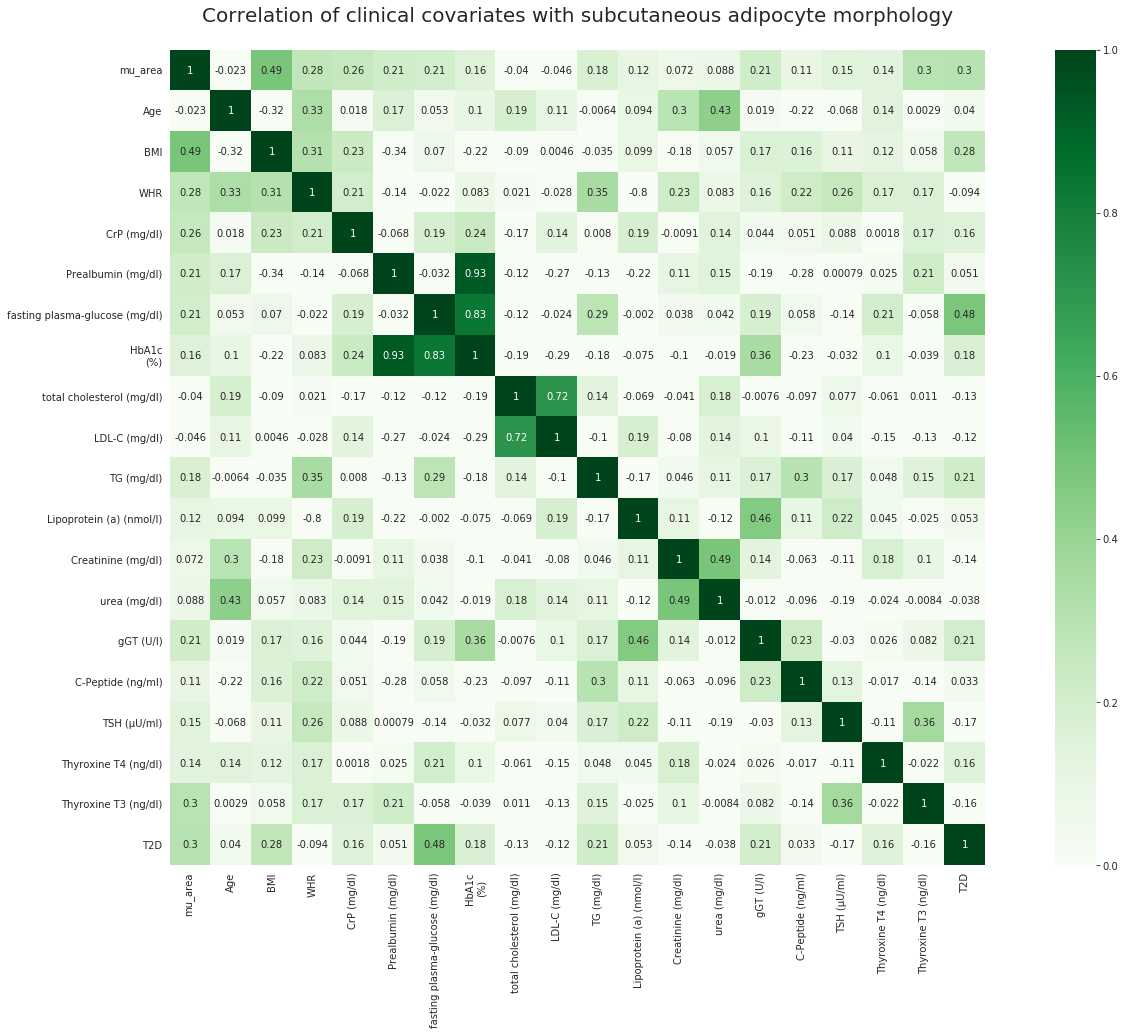

In [31]:
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(visc_corr, cmap='Greens',vmin=0,vmax=1,
            square=True, ax=ax,annot=True,robust=True)
ax.set_title('Correlation of clinical covariates with subcutaneous adipocyte morphology\n',fontsize=20)

Text(0.5, 27.99999999999995, 'Mean Subcutaneous Adipocyte Area ($\\mu m^{2}$)')

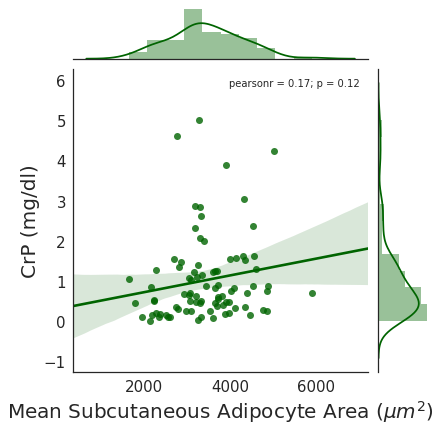

In [104]:
sns.jointplot(x='mu_area',y='CrP (mg/dl)',data=subq_subset,kind='reg',color='darkgreen')
plt.xlabel('Mean Subcutaneous Adipocyte Area ($\mu m^{2}$)')

Text(0.5, 27.99999999999995, 'Mean Visceral Adipocyte Area ($\\mu m^{2}$)')

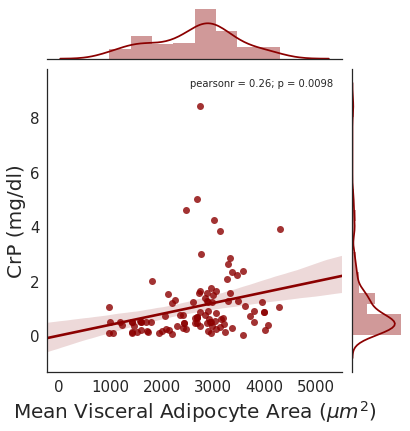

In [105]:
sns.jointplot(x='mu_area',y='CrP (mg/dl)',data=visc_subset,kind='reg',color='darkred')
plt.xlabel('Mean Visceral Adipocyte Area ($\mu m^{2}$)')

In [106]:
subq_subset['Albumin Serum (mg/dl)']=np.array(subq_subset['Albumin Serum (mg/dl)'],dtype='float32')
visc_subset['Albumin Serum (mg/dl)']=np.array(visc_subset['Albumin Serum (mg/dl)'],dtype='float32')

Text(0.5, 27.99999999999995, 'Mean Subcutaneous Adipocyte Area ($\\mu m^{2}$)')

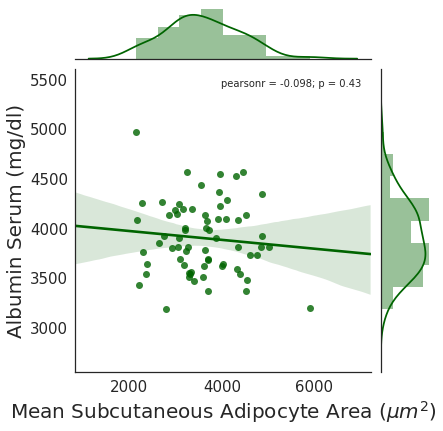

In [107]:
sns.jointplot(x='mu_area',y='Albumin Serum (mg/dl)',data=subq_subset,kind='reg',color='darkgreen')
plt.xlabel('Mean Subcutaneous Adipocyte Area ($\mu m^{2}$)')

Text(0.5, 27.99999999999995, 'Mean Visceral Adipocyte Area ($\\mu m^{2}$)')

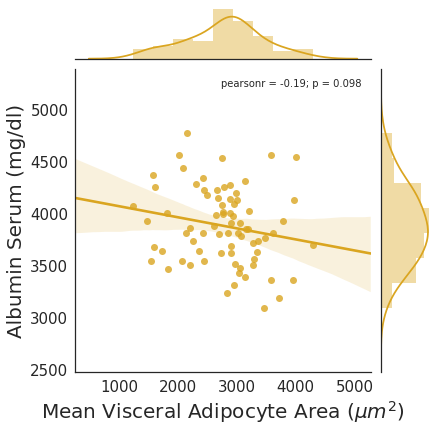

In [108]:
sns.jointplot(x='mu_area',y='Albumin Serum (mg/dl)',data=visc_subset,kind='reg',color='goldenrod')
plt.xlabel('Mean Visceral Adipocyte Area ($\mu m^{2}$)')

Text(0.5, 27.99999999999995, 'Mean Visceral Adipocyte Area ($\\mu m^{2}$)')

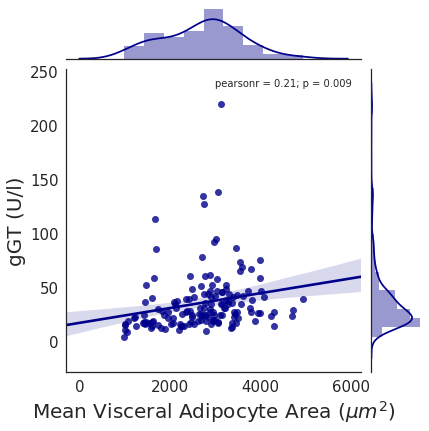

In [109]:
sns.jointplot(x='mu_area',y='gGT (U/l)',data=visc_subset,kind='reg',color='darkblue')
plt.xlabel('Mean Visceral Adipocyte Area ($\mu m^{2}$)')

In [110]:
import statsmodels.api as sm

In [111]:
#Both CrP and gGT in visceral remain sig. after adj. BMI & Age.

In [166]:
X=visc_subset[['gGT (U/l)','BMI','Age']]
X2 = sm.add_constant(X)

est = sm.OLS(visc_subset['mu_area'], X2,missing = 'drop')
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mu_area   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     18.62
Date:                Sat, 29 Dec 2018   Prob (F-statistic):           2.86e-10
Time:                        22:17:23   Log-Likelihood:                -1193.5
No. Observations:                 149   AIC:                             2395.
Df Residuals:                     145   BIC:                             2407.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        682.6498    350.258      1.949      0.053      -9.620    1374.920
gGT (U/l)      3.5772      2.198      1.628      0.106      -0.767       7.921
BMI           32.8310      4.773      6.879      0.000      23.398      42.264
Age           10.2163      4.771      2.141      0.034       0.786      19.646
==============================================================================
Omnibus:                        3.973   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                4.034
Skew:                           0.387   Prob(JB):                        0.133
Kurtosis:                       2.773   Cond. No.                         437.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
X=subq_subset[['gGT (U/l)','BMI','Age']]
X2 = sm.add_constant(X)

est = sm.OLS(subq_subset['mu_area'], X2,missing = 'drop')
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mu_area   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     13.39
Date:                Sat, 29 Dec 2018   Prob (F-statistic):           1.34e-07
Time:                        22:17:33   Log-Likelihood:                -992.14
No. Observations:                 124   AIC:                             1992.
Df Residuals:                     120   BIC:                             2004.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2012.6914    405.084      4.969      0.000    1210.654    2814.729
gGT (U/l)      1.5566      1.964      0.793      0.430      -2.331       5.444
BMI           31.1857      5.540      5.629      0.000      20.216      42.155
Age           -0.7689      5.424     -0.142      0.888     -11.507       9.969
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.765
Skew:                           0.057   Prob(JB):                        0.682
Kurtosis:                       2.632   Cond. No.                         480.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
X=subq_subset[['CrP (mg/dl)','BMI','Age']]
X2 = sm.add_constant(X)

est = sm.OLS(subq_subset['mu_area'], X2,missing = 'drop')
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mu_area   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     9.715
Date:                Sat, 29 Dec 2018   Prob (F-statistic):           1.51e-05
Time:                        22:17:37   Log-Likelihood:                -678.34
No. Observations:                  85   AIC:                             1365.
Df Residuals:                      81   BIC:                             1374.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2459.7152    496.338      4.956      0.000    1472.158    3447.272
CrP (mg/dl)    55.1047     78.476      0.702      0.485    -101.038     211.247
BMI            27.7769      6.534      4.251      0.000      14.775      40.779
Age            -7.6174      6.603     -1.154      0.252     -20.756       5.521
==============================================================================
Omnibus:                        1.758   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.737
Skew:                           0.333   Prob(JB):                        0.419
Kurtosis:                       2.781   Cond. No.                         418.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
X=visc_subset[['CrP (mg/dl)','BMI','Age']]
X2 = sm.add_constant(X)

est = sm.OLS(visc_subset['mu_area'], X2,missing = 'drop')
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mu_area   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     16.29
Date:                Sat, 29 Dec 2018   Prob (F-statistic):           1.28e-08
Time:                        22:17:42   Log-Likelihood:                -781.27
No. Observations:                  99   AIC:                             1571.
Df Residuals:                      95   BIC:                             1581.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         930.8605    383.794      2.425      0.017     168.932    1692.789
CrP (mg/dl)   142.3875     67.717      2.103      0.038       7.953     276.822
BMI            29.9605      5.087      5.890      0.000      19.862      40.059
Age             5.6275      5.245      1.073      0.286      -4.785      16.040
==============================================================================
Omnibus:                        4.635   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                4.389
Skew:                           0.516   Prob(JB):                        0.111
Kurtosis:                       3.009   Cond. No.                         376.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
# Only in visceral is T2D still significant after adjusting for BMI.

In [172]:
X=visc_subset[['T2D','BMI','Age']]
X2 = sm.add_constant(X)

est = sm.OLS(visc_subset['mu_area'], X2,missing = 'drop')
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mu_area   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     21.31
Date:                Sat, 29 Dec 2018   Prob (F-statistic):           1.10e-11
Time:                        22:17:55   Log-Likelihood:                -1327.2
No. Observations:                 166   AIC:                             2662.
Df Residuals:                     162   BIC:                             2675.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        886.0263    337.829      2.623      0.010     218.911    1553.142
T2D          298.4382    133.509      2.235      0.027      34.795     562.081
BMI           30.2758      4.579      6.612      0.000      21.234      39.318
Age            8.7604      4.559      1.921      0.056      -0.243      17.763
==============================================================================
Omnibus:                        6.167   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.264
Skew:                           0.474   Prob(JB):                       0.0436
Kurtosis:                       2.922   Cond. No.                         393.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [181]:
X=visc_subset[['BMI']]
X2 = sm.add_constant(X)

est = sm.OLS(visc_subset['mu_area'], X2,missing = 'drop')
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mu_area   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     28.63
Date:                Sat, 29 Dec 2018   Prob (F-statistic):           2.16e-11
Time:                        22:39:15   Log-Likelihood:                -1337.6
No. Observations:                 167   AIC:                             2681.
Df Residuals:                     164   BIC:                             2690.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        781.3653    335.389      2.330      0.021     119.127    1443.603
BMI           33.3065      4.403      7.564      0.000      24.612      42.001
Age            9.9949      4.541      2.201      0.029       1.028      18.962
==============================================================================
Omnibus:                        4.527   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.613
Skew:                           0.388   Prob(JB):                       0.0996
Kurtosis:                       2.753   Cond. No.                         385.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""